### Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

#### Описание колонок
experimentVariant – вариант эксперимента
version – версия приложения
purchase – факт покупки
 
#### Задача
1. Запустите A/A-тест
2. Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
3. Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [5]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [6]:
df = pd.read_csv('hw_aa.csv', sep=';', index_col=0)

In [7]:
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [8]:
df.shape # Посмотрим кол-во строк и столбцов

(127018, 4)

In [9]:
df.dtypes # Посмотрим тип данных

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [10]:
df.isna().sum() # Посмотрим нулевые значения

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [11]:
df.nunique() #выявляет число уникальных значений по столбцам.

uid                  127018
experimentVariant         2
version                   4
purchase                  2
dtype: int64

Посмотрим как распределены юзеры по версиям?
Больше всего в версии v2.8.0

In [12]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [13]:
# Посмотрим деление на группы?
df.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

In [14]:
df.groupby('experimentVariant', as_index=False).agg({'purchase': 'mean'})
# В среднем  больше всего покупок совершено в первой группе.

,experimentVariant,purchase
0,0,0.023945
1,1,0.053242


In [15]:
df_koeff = df.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase': 'mean', 'uid': 'count'})
df_koeff
# В нулевой группе в версии v2.8.0 больше всего юзеров, но меньше всего покупок

,experimentVariant,version,purchase,uid
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


In [16]:
# Создадим столбец коэфициент покупок
df_koeff["koeff"] = df_koeff.purchase / df_koeff.uid
df_koeff


,experimentVariant,version,purchase,uid,koeff
0,0,v2.8.0,0.000993,41283,2.405699e-08
1,0,v2.9.0,0.074658,11921,6.262744e-06
2,0,v3.7.4.0,0.059943,4204,1.425854e-05
3,0,v3.8.0.0,0.057604,5694,1.011670e-05
4,1,v2.8.0,0.045606,41552,1.097553e-06
5,1,v2.9.0,0.071304,12033,5.925697e-06
6,1,v3.7.4.0,0.063018,4221,1.492969e-05
7,1,v3.8.0.0,0.062848,6110,1.028605e-05


Из df_koeff видно как сильно от всех остальных отличается коффициент покупок в версии v2.8.0. Скорее именно в версии v2.8.0 закралась ошибка.


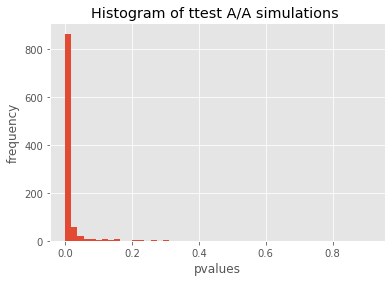

0.935

In [17]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query("experimentVariant == 1").purchase.sample(n_s, replace = False).values
    s2 = df.query("experimentVariant == 0").purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Различия статзначимы. Попробуем доказать, что все версии, кроме одной не дадут таких же результатов (Это мы узнали, пока крутили датафрейм)



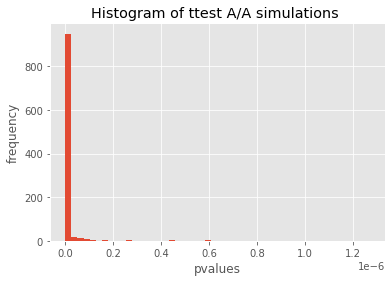

1.0

In [18]:
#По version v2.8.0
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query("experimentVariant == 1 and version == 'v2.8.0'").purchase.sample(n_s, replace = False).values
    s2 = df.query("experimentVariant == 0 and version == 'v2.8.0'").purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Статистически подтверждено, что версия v2.8.0 с багом, проверим, что со всеми остальными данными всё хорошо:

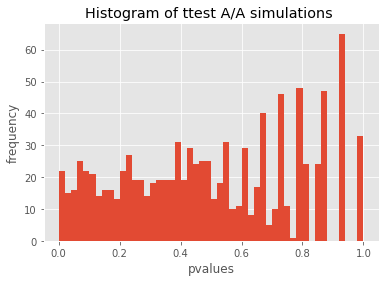

0.041

In [19]:
#По version v2.9.0
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query("experimentVariant == 1 and version == 'v2.9.0'").purchase.sample(n_s, replace = False).values
    s2 = df.query("experimentVariant == 0 and version == 'v2.9.0'").purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

По version v2.9.0 В пределах нормы

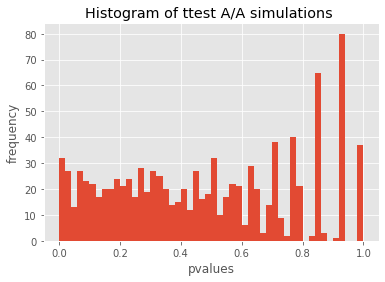

0.065

In [23]:
# По версии v3.8.0.0 
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query("experimentVariant == 1 and version == 'v3.8.0.0'").purchase.sample(n_s, replace = False).values
    s2 = df.query("experimentVariant == 0 and version == 'v3.8.0.0'").purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

По версии v3.8.0.0 в пределах нормы

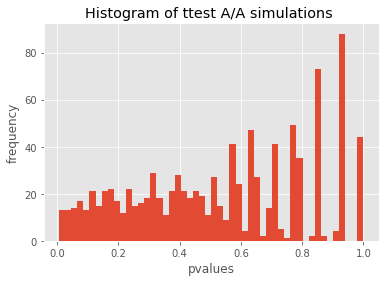

0.028

In [24]:
# По версии v3.7.4.0

res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query("experimentVariant == 1 and version == 'v3.7.4.0'").purchase.sample(n_s, replace = False).values
    s2 = df.query("experimentVariant == 0 and version == 'v3.7.4.0'").purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

По версии v3.7.4.0 в пределах нормы

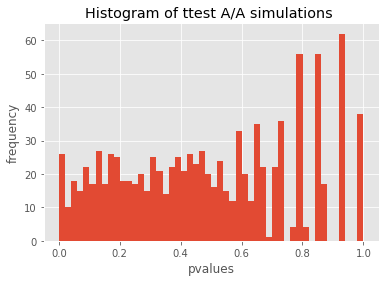

0.042

In [25]:
# Теперь исключим из наших данных версию v2.8.0 с багом и посмотрим:
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df.query("experimentVariant == 1 and version != 'v2.8.0'").purchase.sample(n_s, replace = False).values
    s2 = df.query("experimentVariant == 1 and version != 'v2.8.0'").purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Исключив версию с багом, видим что все в норме.

ВЫВОД.

Покрутив датафрейм мы нашли поломку в версии v2.8.0.
Затем статистически доказали наличие ошибки в версии v2.8.0 и перепроверили себя исключив версию с багом.